In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
import sys
from functools import partial 
from scipy import stats, optimize
import scipy
from tqdm import tqdm
from sympy import *

## The Rayleigh distribution is a PDF given by: f (x) = x σ2 exp−1/2 x2/σ2, with x ∈ [0, ∞]
- By what method(s) would you generate random numbers (from uniform) according to f(x)?

To solve this there is three general approaches:
Inversion: First we try to integrate the function and invert it.
$$F(x) = \int_0^x f(x)dx = 1 - exp(\frac{x^2}{2\sigma^2})$$
We then invert this function 

The Rayleigh distribution is given in the interval [0 : ∞[ thus
in principal the bounding box method would not be possible. But
plotting the function for a reasonable interval of x, we find that the
distribution diverges towards zero quick, and we therefor in principle
would be able to do the bounding box method if we just keep the
shape in mind. Alternativly we could also try to do a smart bound-
ing box that also diverged.
Integrating the function we find that we are able to invert it, and
therefor the inversion method would also be a great choice. The
easiest option would be to use scipy.stats.rayleigh.rvs function to
generate value

Using the inversion method and the rvs module we generate 1000
random values of the distribution and try to fit it with a binned χ2
and unbinned LLH. We get following figure.
Both option work great in this example, but we need to be vary
of the tails of the Rayleigh distribution, a point where the χ2 option
sometimes encounters problems. Here both fits fair well and the
result for σ is consistent for what it is supposed to be

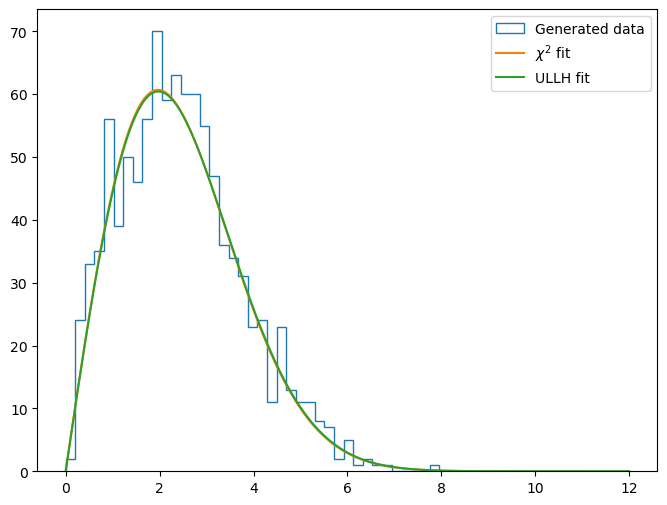

In [9]:
def inv_ray(r,s): # Define the inverse function 
    return np.sqrt(-np.log(1-r)*2*s**2)

def rayleigh(x,s,N): # Rayleigh function to fit to next, we define it twice, one for chi2 fit with the N argument 
    #and one with only the pdf for the loglikelihood
    return N*(x/s**2 * np.exp(-1/2*(x**2/s**2)))

def rayleigh_nn(x,s):
    return (x/s**2 * np.exp(-1/2*(x**2/s**2)))

r_val = np.random.uniform(0,1,1000) # random values between 0 and 1 to sample using the inversion method
x_val = inv_ray(r_val, 2) # Random variates using the inverse method
x_val_stats = stats.rayleigh.rvs(loc = 0, scale = 2, size =1000) # Rvs using the scipy method. Uncomment one or the other to use different methods

bins = np.linspace(0,10,50)
count, bins = np.histogram(x_val, bins)
count_err = np.sqrt(count)
bin_center = (bins[1:] + bins[:-1])/2

chi2_fit = cost.LeastSquares(bin_center[count>0], count[count>0], count_err[count>0], rayleigh)
minuit_chi2 = Minuit(chi2_fit, N = 10, s =2)
minuit_chi2.errordef = 1
minuit_chi2.migrad()

ullh_fit = cost.UnbinnedNLL(x_val, rayleigh_nn)
minuit = Minuit(ullh_fit, s = 2)
minuit.migrad()


bins = np.linspace(0,10,50)
count, bins = np.histogram(x_val_stats, bins)
count_err = np.sqrt(count)
bin_center = (bins[1:] + bins[:-1])/2

chi2_fit = cost.LeastSquares(bin_center[count>0], count[count>0], count_err[count>0], rayleigh)
minuit_chi2_s = Minuit(chi2_fit, N = 10, s =2)
minuit_chi2_s.errordef = 1
minuit_chi2_s.migrad()

ullh_fit = cost.UnbinnedNLL( x_val_stats, rayleigh_nn)
minuit_s = Minuit(ullh_fit, s = 2)
minuit_s.migrad()

x_line = np.linspace(0,12, 1000)
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.hist(x_val, bins, histtype = 'step')
ax.plot(x_line,rayleigh(x_line, *minuit_chi2.values[:]))
ax.plot(x_line,rayleigh(x_line, minuit.values[0],minuit_chi2.values['N']))
#  ax.errorbar(bin_center, count, count_err, ls = '', capsize = 4)
ax.legend(['Generated data',r'$\chi^2$ fit', 'ULLH fit'])
#  plt.show()




We loop over several values for number of samples drawn from
the Rayleigh distribution, and using either χ2 or ULLH, we deter-
mine the error on σ. One thing to keep in mind is to choose a correct
binning for the χ2 method, as this can lead to errors otherwise.

As we are not fitting anything, we can only discuss the GOF, but looking at
the data we can observe that the ULLH fitted data almost fit the line
perfectly, but the χ2 has bigger problems especially at low N, where
the tails for the distribution isn’t as well defined as for higher N.

If we wanted to do an extra check, we could try to plot the residuals to check if it followed a normal distribution, or do a runs test on the data to check if the data follows this trend in a reliable manner.  We dont have a errror on the error, so doing a $\chi^2$ fit to test for goodness of fit we would need to impose an artificial error, where the choice of error would effects the goodness of fit, so we dont get much more informaition about the trend.

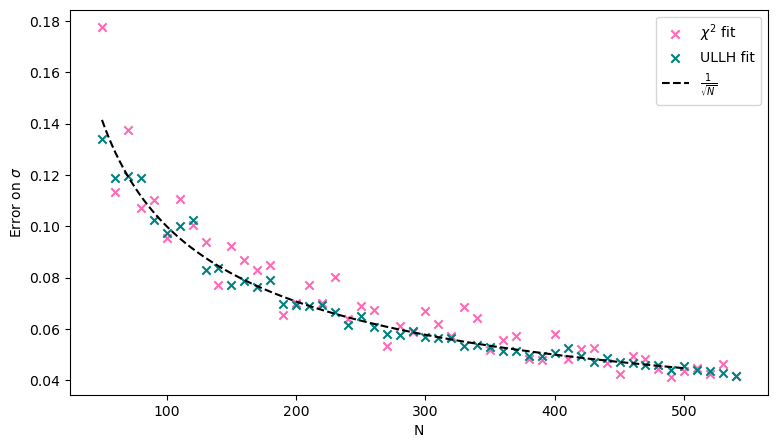

In [16]:
fig, ax = plt.subplots(1,1, figsize = (9,5))

Ns = np.arange(50,550,10)
#  chi2 = np.zeros_like(Ns)
#  ullh = np.zeros_like(Ns)
ullh = []
chi2 = []
for i, N in enumerate(Ns):

    x_val = stats.rayleigh.rvs(loc = 0, scale = 2, size = N)

    bins = np.linspace(0,10,int(np.sqrt(N)))
    count, bins = np.histogram(x_val, bins)
    count_err = np.sqrt(count)
    bin_center = (bins[1:] + bins[:-1])/2

    chi2_fit = cost.LeastSquares( bin_center[count>0], count[count>0], count_err[count>0], rayleigh)
    minuit_chi2 = Minuit(chi2_fit, N = 10, s =2)
    minuit_chi2.errordef = 1
    minuit_chi2.migrad()
    chi2.append(minuit_chi2.errors[0])

    ullh_fit = cost.UnbinnedNLL(x_val, rayleigh_nn)
    minuit = Minuit(ullh_fit, s = 2)
    minuit.errordef = 1
    minuit.migrad()

    ullh.append(minuit.errors[0])

def ullh_sqrt(N, Norm, eps):
    return Norm * eps/np.sqrt(N)


NSS = np.linspace(50,500,500)

ax.scatter(Ns, chi2,marker = 'x', color = 'hotpink',label = r'$\chi^2$ fit') 
ax.scatter(Ns, ullh,marker = 'x', color = 'teal',label = 'ULLH fit') 
ax.plot(NSS, ullh_sqrt(NSS, 1,1), color = 'black', ls = '--', label = r'$\frac{1}{\sqrt{N}}$')
ax.set_xlabel('N')
ax.set_ylabel(r'Error on $\sigma$')
ax.legend()

plt.show()